# Investigation of Nyquist criteria in the context of DEER using a Bayesian approach considering Nyquist for shortest distance in wings of P(r)

This file starts with a low res time trace which barely fulfills Nyquist for the mean distance contained in P(r).
Then a simulation is run that uses a Nyquist frequency thats between the horn and wings of the Pake pattern of the frequency of the shortest distance in P(r) (approx. three detections points per horn oscillation, 1.5 per wing frequency oscillation).
Lastly a simulation is run with a time trace where the Nyquist is too low for either wing or horn frequency of Pake pattern.

## Load packages and setup constants

In [5]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import numpy as np
import math as m
import matplotlib.pyplot as plt
import dive 
import deerlab as dl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Fundamental constants (CODATA 2018)
NA = 6.02214076e23 # Avogadro constant, mol^-1
muB = 9.2740100783e-24 # Bohr magneton, J/T
mu0 = 1.25663706212e-6 # magnetic constant, N A^-2 = T^2 m^3 J^-1
h = 6.62607015e-34 # Planck constant, J/Hz
ge = 2.00231930436256 # free-electron g factor
hbar = h/2/m.pi # reduced Planck constant, J/(rad/s)

w0 = 1e-7*(muB*ge)**2/hbar # rad s^-1

D = (mu0/4/m.pi)*(muB*ge)**2/hbar # dipolar constant, m^3 rad s^-1
D = D/1e6/2/np.pi #--> MHz


# Setup P(r) and determine frequencies for shortest r and mean distance

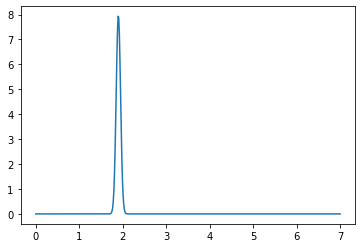

In [7]:
r = np.linspace(0.001,7,500)  

param = [1.9, 0.05]

P = dl.dd_gauss(r,param)

plt.plot(r,P);

In [8]:
idxmin = np.where(P>0.01)[0][0]
idxmean = np.where(P==max(P))[0][0]

rmin = (r[idxmin])
nu_perp = D/(rmin*1e-9)**3
nu_par = 2*nu_perp

print('shortest distance is ' + str(round(rmin,2)) + ' nm')
print('nu_perpendicular = ' + str(round(nu_perp,2)) + ' MHz')
print('nu_parallel = ' + str(round(nu_par,2)) + ' MHz')

rmin = (r[idxmean])
nu_perp = D/(rmin*1e-9)**3
nu_par = 2*nu_perp

print('mean distance is ' + str(round(rmin,2)) + ' nm')
print('nu_perpendicular = ' + str(round(nu_perp,2)) + ' MHz')
print('nu_parallel = ' + str(round(nu_par,2)) + ' MHz')

shortest distance is 1.73 nm
nu_perpendicular = 10.12 MHz
nu_parallel = 20.23 MHz
mean distance is 1.89 nm
nu_perpendicular = 7.65 MHz
nu_parallel = 15.31 MHz


# Experimental parameters (k, λ) and high resolution time trace

In [48]:
lam = 0.5                          # modulation depth
k = 0.01

tmax = 1

In [49]:
t_highres = np.linspace(0,tmax,500)

In [50]:
B_highres = dl.bg_exp(t_highres,k)         # background decay'
K_highres = dl.dipolarkernel(t_highres,r,mod=lam,bg=B_highres)    # kernel matrix

V_highres = K_highres@P + 0*dl.whitegaussnoise(t_highres,0.01,seed=0)  # DEER signal with added noise

# ν<sub>mean,perpendicular</sub> < ν<sub>min,perpendicular</sub> < ν<sub>mean,parallel</sub> < ν<sub>min,parallel</sub> < ν<sub>nyquist</sub>

In [51]:
t = np.linspace(0,tmax,50)

dt = t[2]-t[1]
nu_nyquist = 1/2/dt
r_nyquist = (4 * dt * D)**(1/3)*1e9
nu_min = 2/max(t)

print('Timestep is ' + str(round(dt*1000,2)) + ' ns')
print('Nyquist frequency is ' + str(round(nu_nyquist,2)) + ' MHz')
print('The Nyquist distance is ' + str(round(r_nyquist,2)) + ' nm')
print('Total trace length is ' + str(round(max(t),2)) + ' µs, lowest detectable frequency: ' + str(round(nu_min,2)) + ' MHz')

Timestep is 20.41 ns
Nyquist frequency is 24.5 MHz
The Nyquist distance is 1.62 nm
Total trace length is 1.0 µs, lowest detectable frequency: 2.0 MHz


In [52]:
B = dl.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,mod=lam,bg=B)    # kernel matrix

Vexp = K@P + 0*dl.whitegaussnoise(t,0.01,seed=0)  # DEER signal with added noise

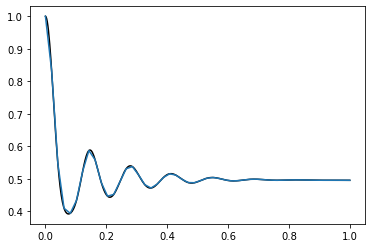

In [53]:
plt.plot(t_highres,V_highres,'k')
plt.plot(t,Vexp)

In [56]:
pars = {"method": 'regularization', "r": np.linspace(0.5,5,100)}

model = dive.model(t, Vexp, pars)

MCMCparameters = {"draws": 5000,"tune": 2000, "chains": 4, 'cores': 4}
trace = dive.sample(model,MCMCparameters)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 136 seconds.
C:\Users\stephan\miniconda3\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 2455 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1279052140370878, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2062 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37580020963047234, but should be close to 0.8. Try to increase the number of tuning steps.
There were 828 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.622649163343815, but should be close

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
k      0.002  0.002   0.000    0.006      0.001    0.001       9.0      50.0   
λ      0.503  0.001   0.502    0.505      0.000    0.000       9.0      27.0   
V₀     1.000  0.001   0.999    1.002      0.000    0.000      36.0      87.0   
σ      0.001  0.000   0.001    0.001      0.000    0.000      11.0      15.0   
δ      0.320  0.128   0.101    0.559      0.001    0.001   18966.0   19980.0   
lg(α) -3.438  0.109  -3.644   -3.235      0.018    0.013      35.0     231.0   

       r_hat  
k       1.37  
λ       1.37  
V₀      1.08  
σ       1.27  
δ       1.00  
lg(α)   1.07

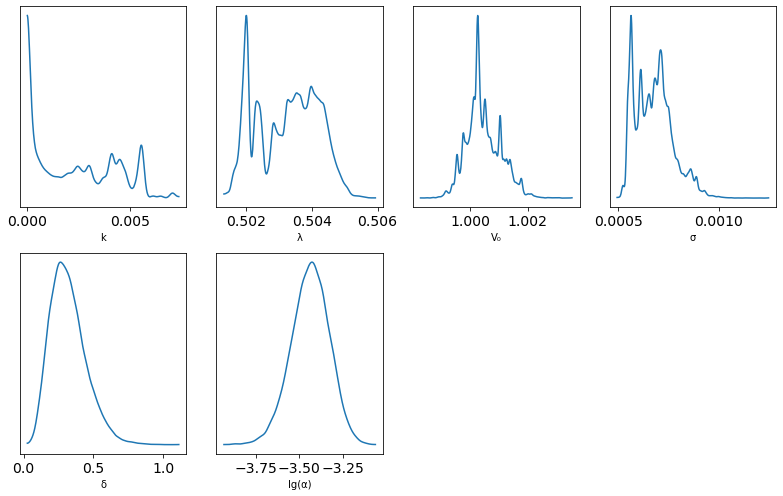

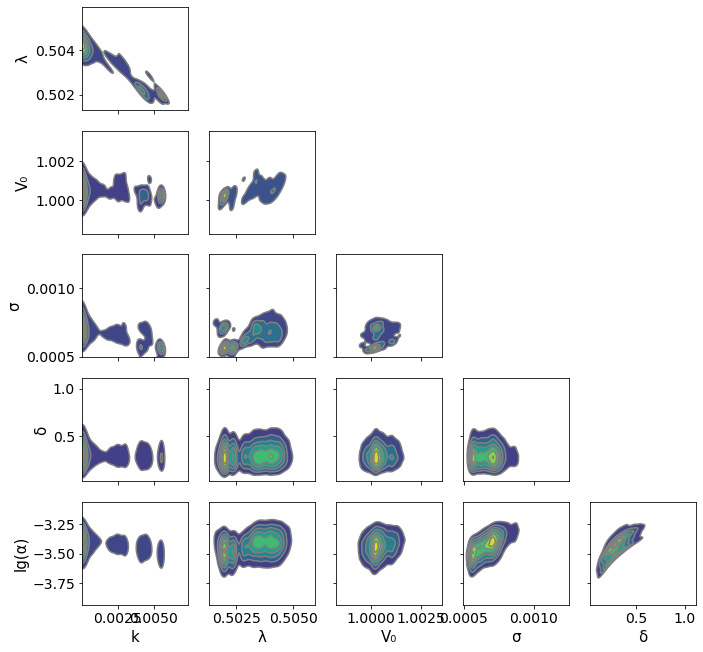

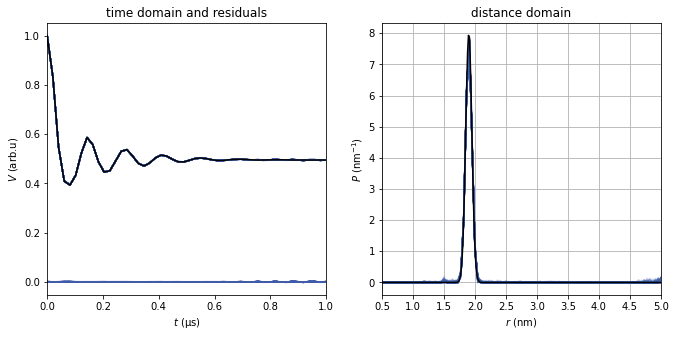

In [57]:
dive.summary(trace, model, Pref = P, rref = r)  

# ν<sub>mean,perpendicular</sub> < ν<sub>min,perpendicular</sub> < ν<sub>nyquist</sub> < ν<sub>mean,parallel</sub> < ν<sub>min,parallel</sub> 

In [58]:
t = np.linspace(0,tmax,25)

dt = t[2]-t[1]
nu_nyquist = 1/2/dt
r_nyquist = (4 * dt * D)**(1/3)*1e9
nu_min = 2/max(t)

print('Timestep is ' + str(round(dt*1000,2)) + ' ns')
print('Nyquist frequency is ' + str(round(nu_nyquist,2)) + ' MHz')
print('The Nyquist distance is ' + str(round(r_nyquist,2)) + ' nm')
print('Total trace length is ' + str(round(max(t),2)) + ' µs, lowest detectable frequency: ' + str(round(nu_min,2)) + ' MHz')

Timestep is 41.67 ns
Nyquist frequency is 12.0 MHz
The Nyquist distance is 2.05 nm
Total trace length is 1.0 µs, lowest detectable frequency: 2.0 MHz


In [59]:
B = dl.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,mod=lam,bg=B)    # kernel matrix

Vexp = K@P + 0*dl.whitegaussnoise(t,0.01,seed=0)  # DEER signal with added noise

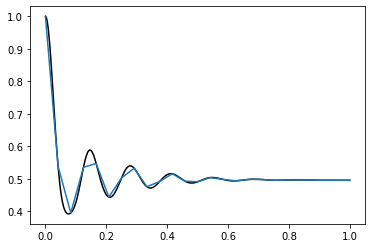

In [60]:
plt.plot(t_highres,V_highres,'k')
plt.plot(t,Vexp)

In [61]:
pars = {"method": 'regularization', "r": np.linspace(0.5,5,100)}

model = dive.model(t, Vexp, pars)

MCMCparameters = {"draws": 5000,"tune": 2000, "chains": 4, 'cores': 4}
trace = dive.sample(model,MCMCparameters)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 349 seconds.
There were 513 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


mean         sd   hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
k          0.014      0.018    0.000      0.048      0.000    0.000    4038.0   
λ          0.500      0.019    0.462      0.533      0.000    0.000    4110.0   
V₀         0.993      0.033    0.929      1.055      0.000    0.000    4536.0   
σ          0.033      0.006    0.023      0.043      0.000    0.000    5229.0   
δ      14646.072  12254.700  645.154  35821.197    656.811  464.826     296.0   
lg(α)      0.523      0.197    0.149      0.889      0.011    0.008     333.0   

       ess_tail  r_hat  
k        4384.0   1.00  
λ        4208.0   1.00  
V₀       5049.0   1.00  
σ        7348.0   1.00  
δ         688.0   1.01  
lg(α)     734.0   1.01

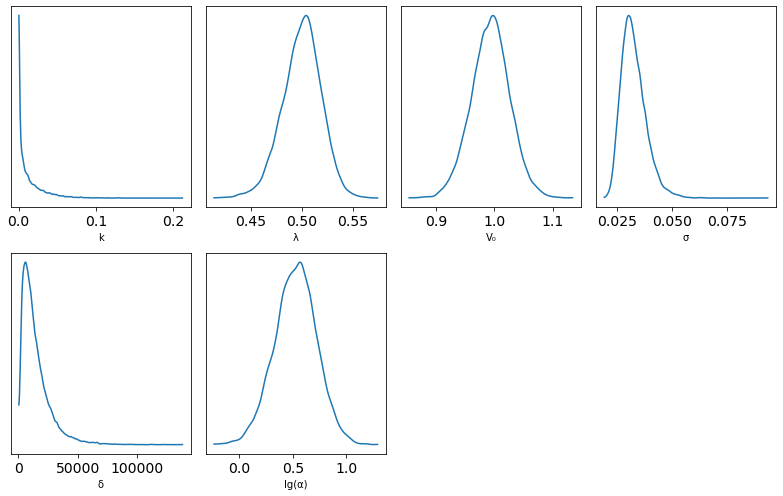

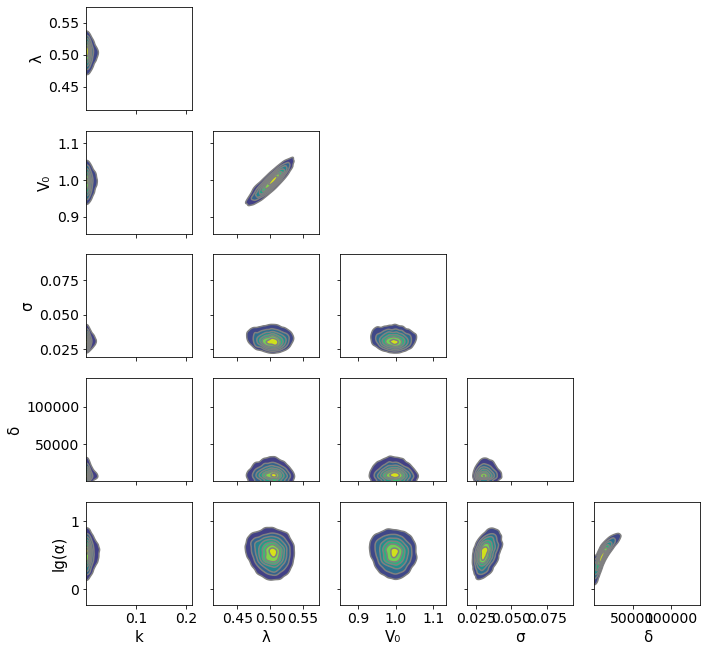

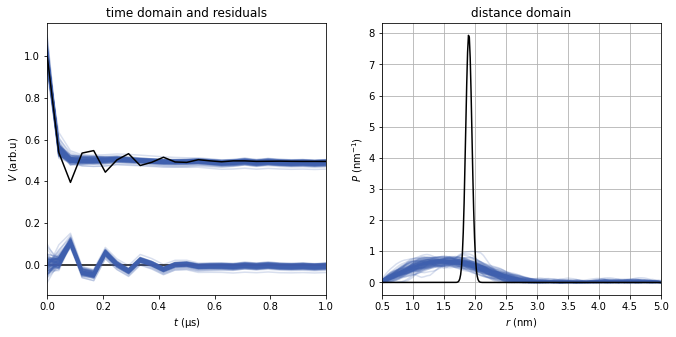

In [62]:
dive.summary(trace, model, Pref = P, rref = r)  

# ν<sub>nyquist</sub> < ν<sub>mean,perpendicular</sub> < ν<sub>min,perpendicular</sub> <  ν<sub>mean,parallel</sub> < ν<sub>min,parallel</sub> 

In [64]:
t = np.linspace(0,tmax,14)

dt = t[2]-t[1]
nu_nyquist = 1/2/dt
r_nyquist = (4 * dt * D)**(1/3)*1e9
nu_min = 2/max(t)

print('Timestep is ' + str(round(dt*1000,2)) + ' ns')
print('Nyquist frequency is ' + str(round(nu_nyquist,2)) + ' MHz')
print('The Nyquist distance is ' + str(round(r_nyquist,2)) + ' nm')
print('Total trace length is ' + str(round(max(t),2)) + ' µs, lowest detectable frequency: ' + str(round(nu_min,2)) + ' MHz')

Timestep is 76.92 ns
Nyquist frequency is 6.5 MHz
The Nyquist distance is 2.52 nm
Total trace length is 1.0 µs, lowest detectable frequency: 2.0 MHz


In [65]:
B = dl.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,mod=lam,bg=B)    # kernel matrix

Vexp = K@P + 0*dl.whitegaussnoise(t,0.01,seed=0)  # DEER signal with added noise

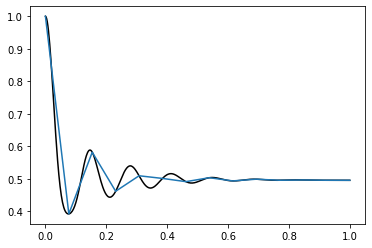

In [66]:
plt.plot(t_highres,V_highres,'k')
plt.plot(t,Vexp);

In [67]:
pars = {"method": 'regularization', "r": np.linspace(0.5,5,100)}

model = dive.model(t, Vexp, pars)

MCMCparameters = {"draws": 5000,"tune": 2000, "chains": 4, 'cores': 4}
trace = dive.sample(model,MCMCparameters)

mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
k        0.005    0.005   0.000    0.014      0.000    0.000    3432.0   
λ        0.503    0.010   0.484    0.521      0.000    0.000    3220.0   
V₀       0.998    0.018   0.964    1.033      0.000    0.000    3645.0   
σ        0.018    0.002   0.015    0.022      0.000    0.000    4126.0   
δ      202.240  160.927   2.632  490.532      3.532    2.498    1638.0   
lg(α)   -0.657    0.196  -1.030   -0.312      0.005    0.004    1667.0   

       ess_tail  r_hat  
k        3758.0   1.00  
λ        3719.0   1.00  
V₀       4533.0   1.00  
σ        4435.0   1.00  
δ        2823.0   1.01  
lg(α)    2830.0   1.01

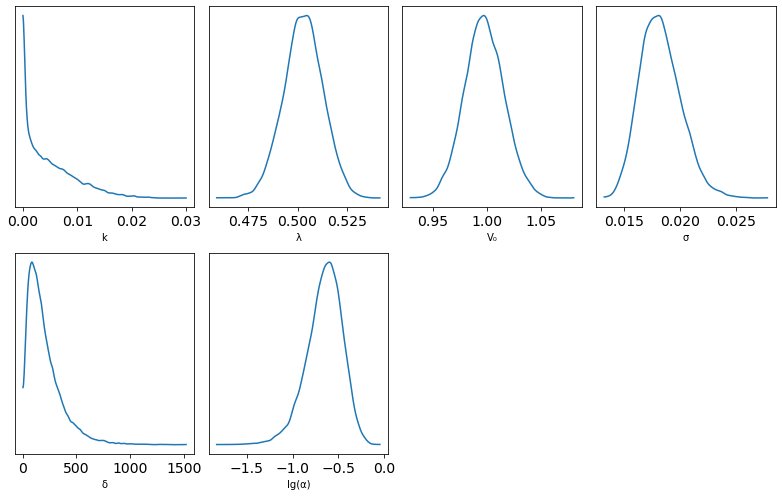

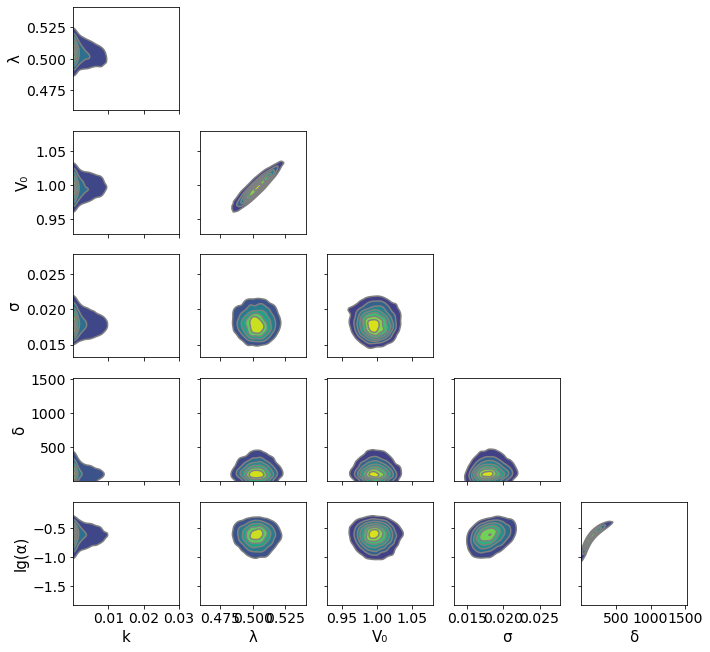

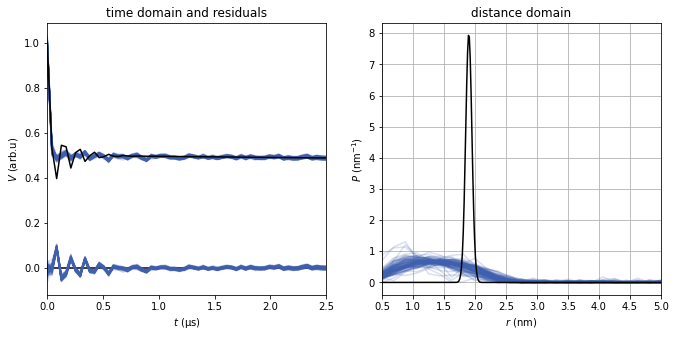

In [42]:
dive.summary(trace, model, Pref = P, rref = r)  